# Read tiles to input format VAE network

### Imports
Install tensorflow:
``%pip install tensorflow``

In [1]:
#%pip install tensorflow

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

### Create sampling layer

In [3]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


### Build encoder


In [4]:
latent_dim = 2
encoder_inputs = keras.Input(shape=(20, 20,3)) # enter cut-out shape (20,20,3)
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x) # to vector
x = layers.Dense(16, activation="relu")(x) # linked layer
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 20, 20, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 10, 10, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 5, 5, 64)     18496       conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 1600)         0           conv2d_1[0][0]                   
____________________________________________________________________________________________

### Build decoder

In [5]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(5 * 5 * 64, activation="relu")(latent_inputs) # -- shape corresponding to encoder
x = layers.Reshape((5, 5, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x) # (1,3) or (3,3)


decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1600)              4800      
_________________________________________________________________
reshape (Reshape)            (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 10, 10, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 20, 20, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 20, 20, 3)         867       
Total params: 61,059
Trainable params: 61,059
Non-trainable params: 0
_______________________________________________________

## Define VAE as model
With custom train_step

In [6]:

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

#     # add CALL to subclass [from https://stackoverflow.com/questions/63822281/issue-with-modifying-a-keras-class-to-include-call-function]
#     def call(self, data):
#         q_z = self.encode(data)
#         z = q_z.sample()
#         x_recon = self.decode(z)
    
    
    
# ---or from: https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/keras/engine/training.py#L320:L328
# ---line 165 

# class MyModel(tf.keras.Model):
#     def __init__(self):
#       super(MyModel, self).__init__()
#       self.dense1 = tf.keras.layers.Dense(4, activation=tf.nn.relu)
#       self.dense2 = tf.keras.layers.Dense(5, activation=tf.nn.softmax)
#     def call(self, inputs):
#       x = self.dense1(inputs)
#       return self.dense2(x)

## Load Data

### mnist dataset

In [7]:
# (x_train, _), (x_test, _) = keras.datasets.mnist.load_data() # reads data as numpy.ndarray

# mnist_digits = np.concatenate([x_train, x_test], axis=0) # [70000,28,28]
# print(type(mnist_digits), np.shape(mnist_digits))

# mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255  # adds 4th dimension (bands) [70000,28,28,1]
# print(type(mnist_digits),np.shape(mnist_digits))



### Stored cut-outs -- UPDATE: made new test-data where labels are included as band. See below
The VAE reads the example mnist data as ndarray. Therefore: read our cut-outs to np.ndarray

#### List cut-out files on disk

In [8]:
# import os
# import numpy as np

# imPath = '/Users/maaikeizeboud/Documents/Data/tiles_test/'
# imgs = sorted([file for file in os.listdir(imPath) if file.endswith('.tif') ]) # list with image names
# len(imgs)

#### Import using rasterio
Importing the .tif images using the keras ``load_img`` functions doesnt work well because it uses Pillow, which has trouble with .tif/.tiff.

The .tif files are read to numpy.ndarray in the NCHW format (bands,rows,cols). Conv2DCustomBackpropInputOp only supports NHWC (Batch Size, Height of the Image, Width of the Image and Number of Channels), so reshape data.

In [9]:
# import rasterio
# rasterio.__version__

In [10]:

# # from rasterio.plot import reshape_as_raster, reshape_as_image

# # get tile size information to initialise ndarray 
# with rasterio.open(imPath + imgs[0]) as src:
#     imShape = [src.width, src.height,src.count]  # returns ( rows , cols, bands)
    
# # initialise ndarray    
# images = np.expand_dims( np.full(imShape,np.nan) , 0)#.astype("float32"); # expand to 4th dimension to stack all images

# # load cut-outs
# for i in imgs[:10]:
#     with rasterio.open(imPath + i) as src:
#         imArray = src.read([1,2,3]) # reads all bands , returns np.ndarray (bands,rows,cols)
# #         imArray = reshape_as_image(imArray) 
#         imArray = np.moveaxis(imArray, 0, -1) # reshapes to (rows,cols,bands)
#         imArray = np.expand_dims(imArray, 0)#.astype("float32")  # ( 1, bands , rows , cols)
#         images = np.concatenate((images, imArray),axis=0) # stack data ( N_imgs, bands, rows, cols)
        
# print(images.shape)
# print(np.min(images),np.max(images))

In [11]:
# # -- normalise images to <0,1> open interval
# imax = np.max(images) # 15.000-ish
# images_norm = (images.astype('float32')+0.1)/ (imax+1) 

# # -- check values in data
# print(np.min(images_norm),np.max(images_norm))
# print('0-values in data: ',np.any(images_norm == 0))
# print('1-values in data: ',np.any(images_norm == 1))
# print('nan-values in data: ',np.any(np.isnan(images_norm)))
# print('inf-values in data: ',np.any(np.isinf(images_norm)))


# Load labelled tile

In [12]:
import rioxarray
import xarray as xr
import numpy as np

In [13]:

dataPath = '/Users/maaikeizeboud/Documents/Data/test/'
imName = 'test_labelled_tile.tif'

In [14]:
tile = rioxarray.open_rasterio(dataPath + imName)
tile.isnull().any()

<xarray.DataArray ()>
array(False)
Coordinates:
    spatial_ref  int64 0

In [15]:
tile

<xarray.DataArray (band: 4, y: 10002, x: 10004)>
array([[[ 9248,  9280, ...,  9232,  9344],
        [ 9336,  9480, ...,  9280,  9328],
        ...,
        [  386,   398, ...,  9608,  9616],
        [  430,   347, ...,  9632,  9632]],

       [[ 9880,  9896, ...,  9496,  9608],
        [ 9856,  9872, ...,  9504,  9616],
        ...,
        [  498,   472, ...,  9856,  9816],
        [  512,   554, ...,  9808,  9880]],

       [[10072, 10088, ...,  9696,  9704],
        [10016, 10104, ...,  9720,  9752],
        ...,
        [  776,   773, ...,  9920,  9920],
        [  726,   785, ...,  9880,  9992]],

       [[    0,     0, ...,     0,     0],
        [    0,     0, ...,     0,     0],
        ...,
        [    0,     0, ...,     0,     0],
        [    0,     0, ...,     0,     0]]], dtype=uint16)
Coordinates:
  * band         (band) int64 1 2 3 4
  * y            (y) float64 -2.667e+05 -2.667e+05 ... -3.667e+05 -3.667e+05
  * x            (x) float64 -1.654e+06 -1.654e+06 ... -1.554e+06 -1.554e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    grid_mapping:  spatial_ref

In [16]:
tile.attrs

{'scale_factor': 1.0, 'add_offset': 0.0, 'grid_mapping': 'spatial_ref'}

### Make cut-out with xarray rolling window

In [17]:
# initialise rolling object
rolling = tile.rolling(
    x=20,
    y=20,
)
rolling

DataArrayRolling [x->20,y->20]

In [18]:

cutouts = rolling.construct(
    {'x':'x_win', 'y': 'y_win'}, 
    stride={'x': 15, 'y': 15}, # windwo_listing uses 'overlap' of 5, which is a stride of 15 for a window of 20pixels
)

In [19]:
cutouts.shape

(4, 667, 667, 20, 20)

In [20]:
# cutouts.isnull().any()

#### Reshape cut-outs 

from dataArray <xarray.DataArray (band: 4, y: 667, x: 667, x_win: 20, y_win: 20)>

to (n: 667*667 , x_win: 20, y_win: 20, bands: 4)

In [21]:
windowlist = cutouts.stack(sample=("y","x"))
windows = windowlist.transpose("sample","x_win","y_win","band")


In [22]:
windows.shape

(444889, 20, 20, 4)

#### issue: cutouts along the edge of the original raster are filled with NaN's - remove

In [23]:
windows.attrs["long_name"] = "bands"
# windows.isel(band=0, sample=0).plot.imshow()

In [24]:
# drop all NaN-containing cutouts - also useful if array has been masked with coastline shape
windows = windows.dropna(dim="sample", how="any")
windows.shape

(442225, 20, 20, 4)

In [25]:
# windows.isel(band=0, sample=0).plot.imshow()

In [28]:
windows.isnull().any()

<xarray.DataArray ()>
array(False)
Coordinates:
    spatial_ref  int64 0

### Make x_train and y_train
Test with fewer samples than in full dataset

In [26]:
nsamples = 1000
x_train = windows[:,:,:,0:3]
y_train = windows[:,:,:,-1]
print(x_train.shape,y_train.shape)

(442225, 20, 20, 3) (442225, 20, 20)


#### Convert xarray.DataArray to numpy ndarray

In [29]:
x_train = x_train.values
y_train = y_train.values

### Normalise data

In [30]:
# print(x_train.max(),x_train.min())
print(np.min(x_train),np.max(x_train))

1.0 17264.0


In [31]:
imax = np.max(x_train) # 15.000-ish
x_train_norm = (x_train+0.1)/ (imax+1) 


In [32]:
data = x_train_norm
print('0-values in data: ',np.any(data == 0))
print('1-values in data: ',np.any(data == 1))


0-values in data:  False
1-values in data:  False


### Each window has a mask on pixel-basis. Convert this to label-per-window
- Sum all pixels in the window
- normalise the values to be 0-1: now we do not have binary label but range label, depending on fracture of window that is classified as crack.

In [34]:
y_train.shape

(442225, 20, 20)

In [35]:
y_label = np.sum(y_train,axis=2)
y_label = np.sum(y_label,axis=1)
y_label.shape

(442225,)

In [67]:
len(y_label[np.where( y_label > 0 )]) # number of windows with label > 0
print(len(y_label[np.where( y_label > 0 )])/len(y_label))

0.00684040929391147


In [36]:
print(np.min(y_label),np.max(y_label))
y_label_norm = (y_label)/ np.max(y_label) # normalise including 0,1 boundaries

print(np.min(y_label_norm),np.max(y_label_norm))


0.0 400.0
0.0 1.0


# Train model

In [37]:
# data = mnist_digits #[70000,28,28,1]
# data = images; #[1001,3,20,20]
# data = images_norm;
data = x_train_norm

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

vae.fit(data, epochs=10, batch_size=128)

# fit model including validation loss
# vae.fit(data, validation_split=0.33, epochs=10, batch_size=10)

Epoch 1/10
3455/3455 [==============================] - 148s 43ms/step - loss: 218.5999 - reconstruction_loss: 214.0885 - kl_loss: 1.5172
Epoch 2/10
3455/3455 [==============================] - 145s 42ms/step - loss: 214.5074 - reconstruction_loss: 213.1968 - kl_loss: 1.3826
Epoch 3/10
3455/3455 [==============================] - 137s 40ms/step - loss: 214.9287 - reconstruction_loss: 213.1319 - kl_loss: 1.3326
Epoch 4/10
3455/3455 [==============================] - 129s 37ms/step - loss: 214.1811 - reconstruction_loss: 212.9671 - kl_loss: 1.3855
Epoch 5/10
3455/3455 [==============================] - 128s 37ms/step - loss: 214.3186 - reconstruction_loss: 212.9098 - kl_loss: 1.3792
Epoch 6/10
3455/3455 [==============================] - 185s 54ms/step - loss: 214.2765 - reconstruction_loss: 212.8860 - kl_loss: 1.3762
Epoch 7/10
3455/3455 [==============================] - 160s 46ms/step - loss: 214.1906 - reconstruction_loss: 212.8689 - kl_loss: 1.3791
Epoch 8/10
3455/3455 [============

## Display grid of sampled images
For the current training-test, the sampled images are very uniform grey data - which makes sense as the network does not distinguish any features yet with this little of training.

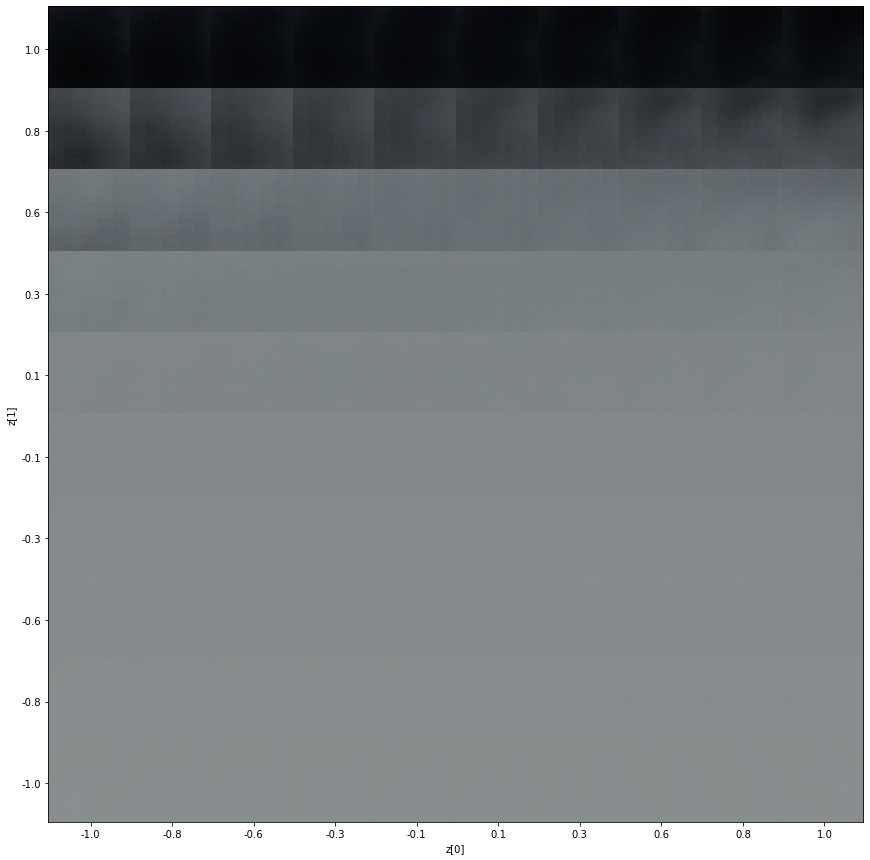

In [38]:
import matplotlib.pyplot as plt


def plot_latent_space(vae, n=10, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 20
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n,3)) #add 3rd dim
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
#             print(x_decoded[0].shape) #[20,20,3]
            digit = x_decoded[0]#.reshape(digit_size, digit_size) # do not reshape: keep all 3 bands
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
                : # add all 3 bands
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='viridis')#"Greys_r")
    plt.show()


plot_latent_space(vae)

### Show original cut-outs.

In [ ]:

# def plot_images(images, n, figsize=15):
#     # display a n*n 2D manifold of images
    
#     fig, axes = plt.subplots(n, n,figsize=(figsize,figsize))
#     fig.suptitle('Display set of '+ str(n**2) +' cut-outs')

#     k=0;
#     for i in range(n):
#         for j in range(n):
#             ax = axes[i,j]
#             ax.imshow(images[k,:,:,0],cmap='Greys_r')
#             k+=1

# plot_images(images_norm,5)   

## Display latent space clustering

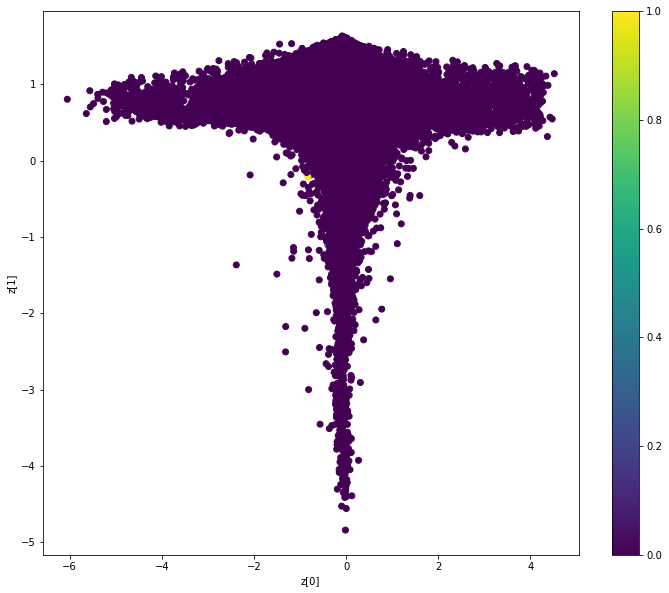

In [40]:

def plot_label_clusters(vae, data,labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
#     plt.scatter(z_mean[:,0],z_mean[:,1])
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


# (x_train, y_train), _ = keras.datasets.mnist.load_data()
# x_train = np.expand_dims(x_train, -1).astype("float32") / 255
# x_train = data;
# y_train = np.zeros(len(data))

plot_label_clusters(vae, x_train_norm, y_label_norm)

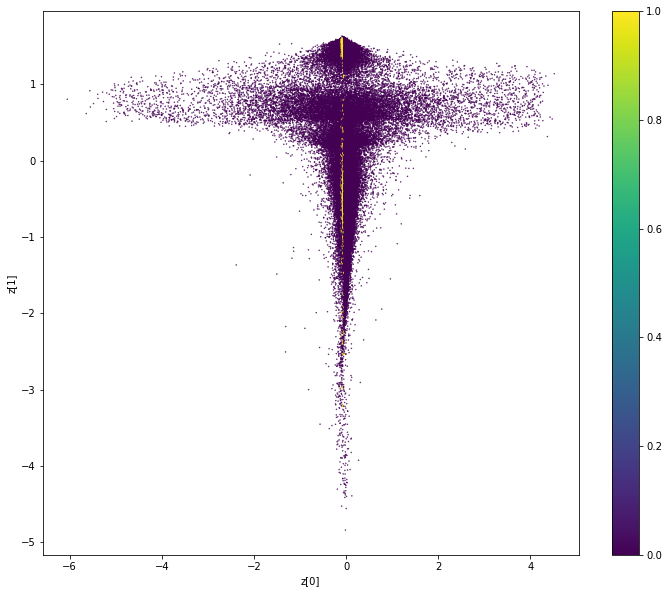

In [58]:

def plot_label_clusters2(vae, data,labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    z_mean = z_mean[z_mean[:,0].argsort()] # sort for 1 column
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels,s=(labels+0.1)*2) # also add size for scatter point
#     plt.scatter(z_mean[:,0],z_mean[:,1])
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


# (x_train, y_train), _ = keras.datasets.mnist.load_data()
# x_train = np.expand_dims(x_train, -1).astype("float32") / 255
# x_train = data;
# y_train = np.zeros(len(data))

plot_label_clusters2(vae, x_train_norm, y_label_norm)